### Chapter 1: Dataset Introduction

This section contains step-by-step instructions about how we create this simple logic game dataset. The final part of the output contains all the logic programs we selected to train the model. This script can be also used to generate other logic programs, and our set is not an exhaustive set.


In [1]:
from utils import *

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    
set_seed(42)

#### Loading some pre-generated vocabs.

Here, we focus on a set of synonyms and antonyms pairs generated by GPT-4. We use them as the vocab of the game.

In [4]:
all_vocab, synonyms_pairs, synonyms_dict = fetch_metadata(".")

#### Using our own DSLs, and a sort of PCFG, we generate all the programs that are possible.

Note that these programs are not all valid! In fact, a lot of them can be equivalent programs which we need to filter out. The following steps include our first filtering step applied, which is to run the same input-output pairs for each program, and filter out those programs have biased output label distribution (e.g., 100% False and 0% True) just to make the results a little cleaner afterwards.

**Worth for you to think**: by making the problem cleaner, we are also sort of *making the interpretability problem easier*. After a very restrict filtering, it almost can be seen as there are only certain ways to solve each program at the end, which could potentially make the circuit discovery process easier. But, as we focus on interpretability after all, easier-to-find circuits are still interesting and relevant. It is good to keep this mind.

In [8]:
programs = generate_programs()
balanced_programs = []
program_value_map = {}
for p in programs:
    program_value_map[p] = []
    for i in range(1000):
        outputs = sample_factual_inputs(p, all_vocab, synonyms_pairs, synonyms_dict)
        eval_out = eval_program(outputs[0], outputs[1], synonyms_pairs, synonyms_dict)
        if eval_out != outputs[-1]['op5']:
            print(outputs)
            print(eval_out)
            FAIL()
        program_value_map[p].append(outputs[-1]['op5'])
    counter = Counter(program_value_map[p])
    if float(counter[True]/counter[False]) <= 1.5 and float(counter[True]/counter[False]) >= 0.66:
        balanced_programs.append(p)

In [9]:
print(f"total n program = {len(programs)}; balanced n program = {len(balanced_programs)}")

total n program = 5760; balanced n program = 187


#### Potentially equivalent program detection

Given a set of inputs, we measure the correlation of outputs between two programs when evaluated on the same inputs. Obviously, a program will correlate with itself with a coefficient of 1.0. And the higher, the more correlated two programs are. We filter out programs that are very similar.

In [20]:
# baysian checks.
progress_count = 0
all_scores = []
for p in tqdm(balanced_programs):
    progress_count += 1
    outputs_collect = []
    p_outs = []
    for i in range(1000):
        outputs = sample_factual_inputs(p, all_vocab, synonyms_pairs, synonyms_dict)
        outputs_collect += [outputs]
        p_outs += [outputs[-1]['op5']]
    p_outs = np.array(p_outs)
    
    similarity_scores = []
    for compare_to_p in balanced_programs:
        eval_outs = []
        for outputs in outputs_collect:
            eval_out = eval_program(compare_to_p, outputs[1], synonyms_pairs, synonyms_dict)
            eval_outs += [eval_out]
        similarity_score = (np.array(eval_outs)==p_outs).sum()/len(outputs_collect)
        similarity_scores += [similarity_score]
    all_scores += [similarity_scores]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [49:38<00:00, 15.93s/it]


Let's visualize the correlations between programs.

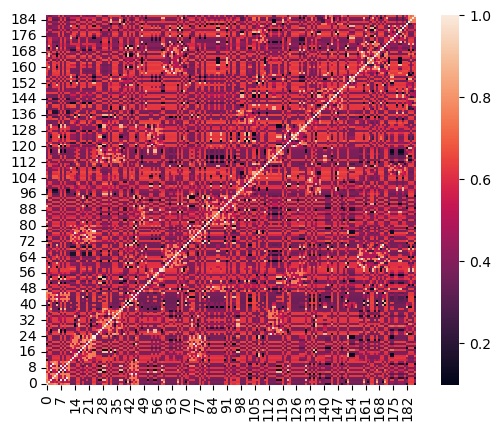

In [22]:
all_scores = np.array(all_scores)
sns.heatmap(all_scores, square=True)
plt.xlim(0, all_scores.shape[0])
plt.ylim(0, all_scores.shape[1])
plt.show()

Now, for each program, we can then have a "good list" of programs that are weakly correlate with it. Note that the score is represented by the count of same outputs between two programs. If the number is very low, meaning it is very easy to distinguish these two programs, which means we don't need to have that many demonstrations. So, we want to make the task harder to restrict the lower bound.

We simply use a greedy-search to find that list.

In [62]:
current_set = list(weakly_correlated_variables(all_scores, 0.7))
filtered_balanced_programs = [balanced_programs[idx] for idx in list(current_set)]

We then verify this set is good, a.k.a there is no pair of programs have highly correlated input-output behaviors.

In [64]:
filtered_scores = []
for p in tqdm(filtered_balanced_programs):
    outputs_collect = []
    p_outs = []
    for i in range(1000):
        outputs = sample_factual_inputs(p, all_vocab, synonyms_pairs, synonyms_dict)
        outputs_collect += [outputs]
        p_outs += [outputs[-1]['op5']]
    p_outs = np.array(p_outs)
    
    similarity_scores = []
    for compare_to_p in filtered_balanced_programs:
        eval_outs = []
        for outputs in outputs_collect:
            eval_out = eval_program(compare_to_p, outputs[1], synonyms_pairs, synonyms_dict)
            eval_outs += [eval_out]
        similarity_score = (np.array(eval_outs)==p_outs).sum()/len(outputs_collect)
        similarity_scores += [similarity_score]
    filtered_scores += [similarity_scores]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:14<00:00,  2.48s/it]


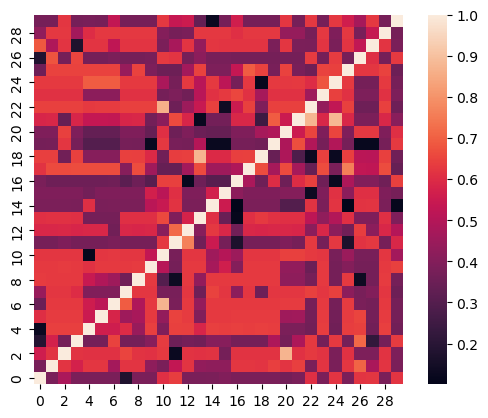

In [66]:
filtered_scores = np.array(filtered_scores)
sns.heatmap(filtered_scores, square=True)
plt.xlim(0, filtered_scores.shape[0])
plt.ylim(0, filtered_scores.shape[1])
plt.show()

#### DONE!

Okay, now we have a good list of programs (**30!**) to start to build our meta-learner, and do alignments on the meta-learner!

In [69]:
out_file = open("seed_programs.json", "w")
json.dump(filtered_balanced_programs, out_file, indent = 2)
out_file.close()

### Chapter 2: Dataset Creation

We will demo functions to create factual training data, as well as counterfactual training data for alignment. Note that, since the task is a simple synthetic task, the actual dataset will be created on-the-fly during the start of the training code. This is just a demo, there will not a saved dataset somewhere.

In [127]:
# let's load a program from the disk.
programs = json.load(open("seed_programs.json"))
program = random.choice(list(programs.items()))

In [129]:
# you just need to print out what a program looks like.
# program is serialized in the following format.
"""
[
    [[synonym_left, synonym_right], 's', [first_op_left, first_op_right/second_op_left, second_op_right]],
    [[second_logic_left, second_logic_right], '<logic_gate>'],
    [third_logic_right, '<logic_gate>']
]
"""
program

('ee6b4a',
 [[[1, 3], 's', [4, 0, 2], ['==', '!=']], [[5, 7], 'OR'], [6, 'AND']])

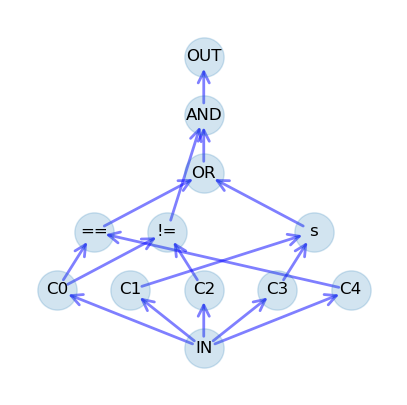

In [132]:
# you can also visualize your program.
visualize_program(program[1])

In [133]:
# based on this program, we can then sample factual inputs.
sample_factual_inputs(program[1], all_vocab, synonyms_pairs, synonyms_dict)

([[[1, 3], 's', [4, 0, 2], ['==', '!=']], [[5, 7], 'OR'], [6, 'AND']],
 {4: 'authentic', 0: 'true', 2: 'true', 1: 'random', 3: 'laughter'},
 {'op1': '==', 'op2': '!=', 'op3': 's', 'op4': 'OR', 'op5': 'AND'},
 {'op1': False, 'op2': False, 'op3': False, 'op4': False, 'op5': False})

As you can see, we now sample inputs as well as the output conditioned on these inputs and the program. So far, we already have all the components to train a network to solve these programs. Let's finetune one and the get to the counterfactual dataset creation.

In [2]:
def sample_factual_input_instruction(program):
    digit_to_word_mapping = {
        0 : "first", 
        1 : "second", 
        2 : "third", 
        3 : "fourth",
        4 : "fifth"
    }
    
    first_same_or_not = "the same" if program[0][3][0] == "==" else "not the same"
    second_same_or_not = "the same" if program[0][3][1] == "==" else "not the same"
    second_part = f"A is True if "\
                  f"the {digit_to_word_mapping[program[0][2][0]]} word "\
                  f"and the {digit_to_word_mapping[program[0][2][1]]} word are {first_same_or_not}, otherwise False."
    third_part = f"B is True if "\
                  f"the {digit_to_word_mapping[program[0][2][1]]} word "\
                  f"and the {digit_to_word_mapping[program[0][2][2]]} word are {second_same_or_not}, otherwise False."
    
    first_part = f"C is True if "\
                 f"the {digit_to_word_mapping[program[0][0][0]]} word "\
                 f"and the {digit_to_word_mapping[program[0][0][1]]} word are synonyms, otherwise False."
    
    first_logic_gate = "and" if program[1][-1] == "AND" else "or"
    second_logic_gate = "and" if program[-1][-1] == "AND" else "or"
    
    first_left_var = "A" if program[1][0][0] == 5 else "B" if program[1][0][0] == 6 else "C"
    first_right_var = "A" if program[1][0][1] == 5 else "B" if program[1][0][1] == 6 else "C"
    second_var = "A" if program[-1][0] == 5 else "B" if program[-1][0] == 6 else "C"
    
    fourth_part = f"D is True if "\
                  f"{first_left_var} {first_logic_gate} {first_right_var} is True, otherwise False."
    
    fifth_part = f"The output is True if "\
                  f"{second_var} {second_logic_gate} D is True, otherwise False."
    
    # test_demo = "What is the output? "
    
    program_str = "\n".join([second_part, third_part, first_part, fourth_part, fifth_part])
    return program_str

"""
To make this more compatible with HF, maybe let's 
make this as a seq to seq task where the input is 
a sentence of words, and the output is also a single
word in this case.
"""

def prepare_factual_training_data_single_program(
    program, 
    n_sample, 
    n_in_context_demo,
    data_path=".",
    input_trigger="INPUT",
    output_trigger="OUTPUT",
    program_uuid=None,
    mode="I" # ["[I]nstructions", "[E]xplainations", "[N]umber"]
):
    if mode == "E":
        prompt_starter="Based on given word sets, deduce the "\
                       "hidden rule involving word equality and "\
                       "synonymy from given examples in the context "\
                       "and apply the deduced rule to the new input."
    else:
        prompt_starter="Based on the given rule involving word "\
                       "equality and synonymy for a given input, "\
                       "apply the rule to the new input."
        task_instruction = sample_factual_input_instruction(program)
    instruction_template = """Instruction:
%s

Context:
%s

Response:
%s"""
    all_vocab, synonyms_pairs, synonyms_dict = fetch_metadata(data_path)
    demo_sep="\n"
    count = 0
    examples = []
    unique_hash_set = set([])
    while len(examples) < n_sample:
        if mode == "E":
            demos = []
            for _ in range(n_in_context_demo):
                program, inputs, op_maps, value_maps = sample_factual_inputs(
                    program, all_vocab, synonyms_pairs, synonyms_dict
                )
                input_words = [inputs[i] for i in range(len(inputs))]
                input_sentence = " ".join(input_words)
                output_word = value_maps[f'op{len(inputs)}']
                single_demo = f"{input_trigger} {input_sentence} {output_trigger} {output_word}"
                demos += [single_demo]
            program, inputs, op_maps, value_maps = sample_factual_inputs(
                program, all_vocab, synonyms_pairs, synonyms_dict
            )
            test_words = [inputs[i] for i in range(len(inputs))]
            test_sentence = " ".join(test_words)
            test_demo = f"{input_trigger} {test_sentence} {output_trigger} "
            demos = "\n".join(demos)
            answers = value_maps[f'op{len(inputs)}']
            question = instruction_template % (prompt_starter, demos, test_demo)
            task_name = "word_logic_E"
        elif mode == "I":
            program, inputs, op_maps, value_maps = sample_factual_inputs(
                program, all_vocab, synonyms_pairs, synonyms_dict
            )
            test_words = [inputs[i] for i in range(len(inputs))]
            test_sentence = " ".join(test_words)
            test_demo = f"{input_trigger} {test_sentence} {output_trigger} "
            answers = value_maps[f'op{len(inputs)}']
            question = instruction_template % (prompt_starter, task_instruction, test_demo)
            task_name = "word_logic_I"
        elif mode == "N":
            assert program_uuid is not None, "The mode N requires a program UUID."
            program, inputs, op_maps, value_maps = sample_factual_inputs(
                program, all_vocab, synonyms_pairs, synonyms_dict
            )
            test_words = [inputs[i] for i in range(len(inputs))]
            test_sentence = " ".join(test_words)
            test_demo = f"{input_trigger} {test_sentence} {output_trigger} "
            answers = value_maps[f'op{len(inputs)}']
            question = instruction_template % (prompt_starter, program_uuid, test_demo)
            task_name = "word_logic_N"
        else:
            assert False, f"The mode {mode} is unknown."

        if f"{question} {answers}" not in unique_hash_set:
            example = {
                "question": question,
                "answers": answers,
                "program": program,
                "task_name": task_name
            }
            examples += [example]
            unique_hash_set.add(f"{question} {answers}")
    return examples

In [145]:
prepare_factual_training_data_single_program(
    program[1],
    3, 
    10,
    mode="N",
    program_uuid=program[0],
)

[{'question': 'Instruction:\nBased on the given rule involving word equality and synonymy for a given input, apply the rule to the new input.\n\nContext:\nee6b4a\n\nResponse:\nINPUT advance advance please progress advance OUTPUT ',
  'answers': True,
  'program': [[[1, 3], 's', [4, 0, 2], ['==', '!=']],
   [[5, 7], 'OR'],
   [6, 'AND']],
  'task_name': 'word_logic_N'},
 {'question': 'Instruction:\nBased on the given rule involving word equality and synonymy for a given input, apply the rule to the new input.\n\nContext:\nee6b4a\n\nResponse:\nINPUT fearless weary bold fix daring OUTPUT ',
  'answers': False,
  'program': [[[1, 3], 's', [4, 0, 2], ['==', '!=']],
   [[5, 7], 'OR'],
   [6, 'AND']],
  'task_name': 'word_logic_N'},
 {'question': 'Instruction:\nBased on the given rule involving word equality and synonymy for a given input, apply the rule to the new input.\n\nContext:\nee6b4a\n\nResponse:\nINPUT glitter lead glitter first sparkle OUTPUT ',
  'answers': False,
  'program': [[[1

### Chapter 3: Counterfactual Dataset Creation

TBD